In [1]:
from PandaSQLite import PandaSQLiteDB
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
db = PandaSQLiteDB("data.sql", auto_commit=False)

In [95]:
db.import_data("par_blas","./data/par-blas.dat", format="csv")
db.import_data("par_blocked","./data/par-blocked.dat", format="csv")
db.import_data("seq_blas","./data/seq-blas.dat", format="csv")
db.import_data("seq_blocked","./data/seq-blocked.dat", format="csv")
db.import_data("seq_naive","./data/seq-naive.dat", format="csv")

In [96]:
db.show_tables()

name
0     par_blas
1  par_blocked
2     seq_blas
3  seq_blocked
4    seq_naive

In [97]:
for n in db.show_tables()["name"]:
    db.execute(f"ALTER TABLE {n} ADD COLUMN name TEXT")
    db.execute(f"UPDATE {n} SET name='{n}'")


In [98]:
db.execute("CREATE TABLE par AS SELECT * FROM par_blas UNION ALL SELECT * FROM par_blocked")

In [99]:
db.execute("ALTER TABLE par RENAME COLUMN name TO Algorithm")

In [47]:
db.execute(f"UPDATE seq SET Algorithm='MKL BLAS' WHERE Algorithm='seq_blas'")
db.execute(f"UPDATE seq SET Algorithm='Blocked MM' WHERE Algorithm='seq_blocked'")
db.execute(f"UPDATE seq SET Algorithm='Naive MM' WHERE Algorithm='seq_naive'")

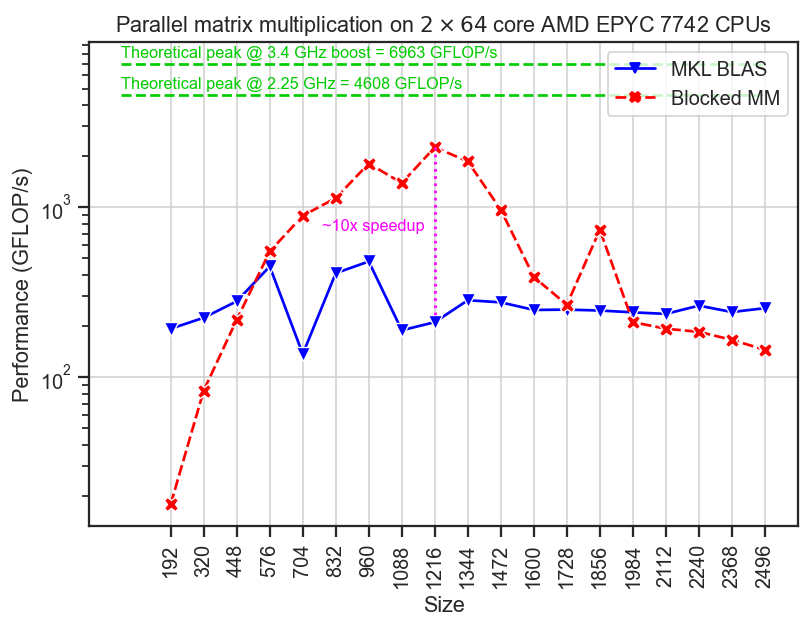

In [63]:
fig, ax = plt.subplots(dpi=130)
sns.set_theme()
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"
sns.lineplot(
    data=db.query("SELECT size, Algorithm, \" perf\"/1000 AS p FROM par"),
    x="size", 
    y="p",
    hue="Algorithm",
    style="Algorithm",
    markers=["v", "X"], 
    palette=["blue", "red"],
    markersize=8,
    ax=ax
).set_title(r"Parallel matrix multiplication on $2\times64$ core AMD EPYC 7742 CPUs")

ax.set_yscale("log", base=10)
ax.grid(alpha=0.8)
ax.set_xlabel("Size")
ax.set_ylabel("Performance (GFLOP/s)")

# Add green text above the hline
ax.text(0, 4800, "Theoretical peak @ 2.25 GHz = 4608 GFLOP/s", ha="left", va="bottom", color="#00CC00", fontsize=9)
ax.hlines(4608, 0, 2500, color="#00CC00", linestyles="dashed")

ax.text(0, 7300, "Theoretical peak @ 3.4 GHz boost = 6963 GFLOP/s", ha="left", va="bottom", color="#00CC00", fontsize=9)
ax.hlines(6963, 0, 2500, color="#00CC00", linestyles="dashed")
plt.tight_layout()
leg = ax.legend()
leg.set_alpha(1.0)

# Increase the number of y-axis tick labels
ytick_values = [10**i for i in range(1, 5)]
ax.set_yticks(ytick_values)

# Increase the number of x-axis tick labels
xtick_values = db.query("SELECT DISTINCT size FROM par ORDER BY size DESC")["size"]
plt.xticks(xtick_values, rotation="vertical")
ax.vlines(1216, 2258.790, 220, color="magenta", linestyles="dotted")
ax.text(780, 700, "~10x speedup", ha="left", va="bottom", color="magenta", fontsize=9)
plt.savefig("par.pdf")





In [4]:
db.execute("CREATE TABLE seq AS SELECT * FROM seq_blas UNION ALL SELECT * FROM seq_blocked UNION ALL SELECT * FROM seq_naive")

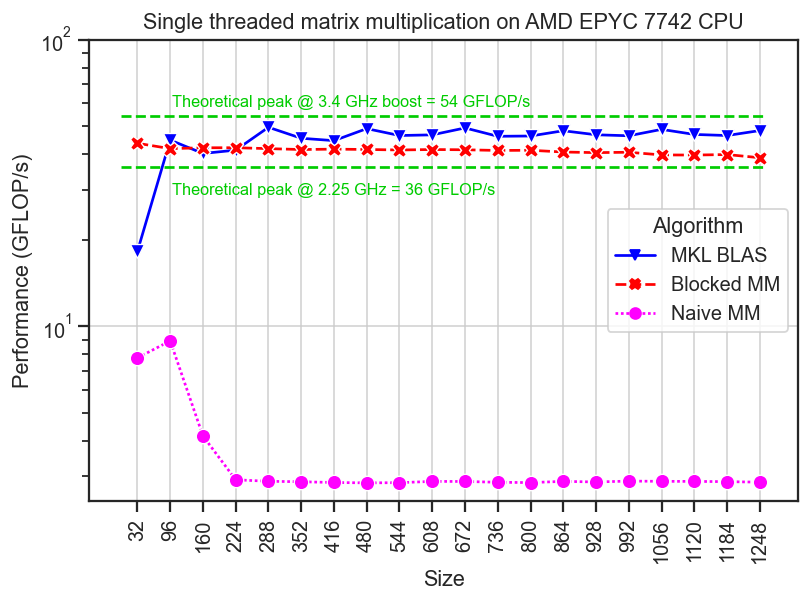

In [23]:
fig, ax = plt.subplots(dpi=130)
sns.set_theme()
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"
sns.lineplot(
    data=db.query("SELECT size, Algorithm, \"perf\"/1000 AS p FROM seq"),
    x="size", 
    y="p",
    hue="Algorithm",
    style="Algorithm",
    markers=["v", "X", 'o'], 
    palette=["blue", "red", "magenta"],
    markersize=8,
    ax=ax
).set_title(r"Single threaded matrix multiplication on AMD EPYC 7742 CPU")

ax.set_yscale("log", base=10)
ax.grid(alpha=0.8)
ax.set_xlabel("Size")
ax.set_ylabel("Performance (GFLOP/s)")

# Add green text above the hline
ax.text(100, 28, "Theoretical peak @ 2.25 GHz = 36 GFLOP/s", ha="left", va="bottom", color="#00CC00", fontsize=9)
ax.text(100, 57, "Theoretical peak @ 3.4 GHz boost = 54 GFLOP/s", ha="left", va="bottom", color="#00CC00", fontsize=9)
ax.hlines(36, 0, 1260, color="#00CC00", linestyles="dashed")
ax.hlines(54.4, 0, 1260, color="#00CC00", linestyles="dashed")
#ax.set_ylim(0, 3700)

# Increase the number of y-axis tick labels
ytick_values = [10**i for i in range(1, 3)]
ax.set_yticks(ytick_values)

# Increase the number of x-axis tick labels
xtick_values = db.query("SELECT DISTINCT size FROM seq ORDER BY size DESC")["size"]
plt.xticks(xtick_values, rotation="vertical")

plt.tight_layout()
plt.savefig("seq.pdf")


In [51]:
l = db.query("SELECT DISTINCT size FROM par ORDER BY size ASC")["size"]
for k in l:
    print(f"{k}, ", end="")

192, 320, 448, 576, 704, 832, 960, 1088, 1216, 1344, 1472, 1600, 1728, 1856, 1984, 2112, 2240, 2368, 2496, 

In [3]:
db.import_data("racklette_mem", "./data/racklette-mem.csv")

In [11]:
db.get_table("racklette_mem")

size    stride       rw     sec       cycles    steps
0         512         4    0.388   1.000    213487780  2015291
1         512         8    0.429   1.000    326080067  1821731
2         512        16    0.365   1.000    -59211160  2138548
3         512        32    0.356   1.000   -149118783  2191893
4         512        64    0.437   1.000    362122908  1786299
..        ...       ...      ...     ...          ...      ...
274  67108864   2097152  211.399  35.467  79738797241        1
275  67108864   4194304   35.215   5.908  13156435350        1
276  67108864   8388608    0.668   1.008    980333572        9
277  67108864  16777216    1.256   1.054   1852843049        5
278  67108864  33554432    2.218   1.116   2255650381        3

[279 rows x 6 columns]

/var/folders/7w/xd28j9bd12gf6d3mhwgtpzg00000gn/T/ipykernel_23564/1308191248.py:7: UserWarning: 
The palette list has fewer values (10) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


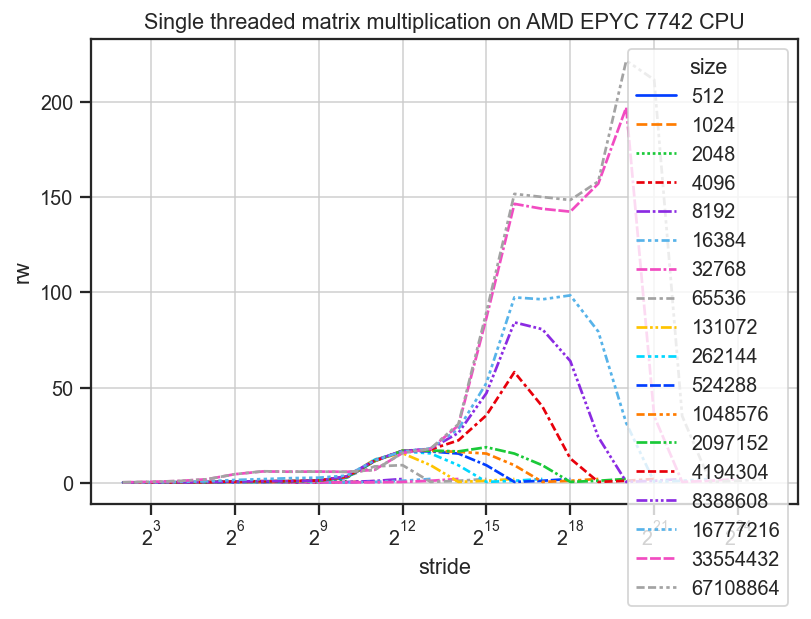

In [4]:
fig, ax = plt.subplots(dpi=130)
sns.set_theme()
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"
sns.lineplot(
    data=db.query("SELECT stride, rw, size FROM racklette_mem"),
    x="stride", 
    y="rw",
    hue="size",
    palette=colors,
    style="size",
    markersize=8,
    ax=ax
).set_title(r"Single threaded matrix multiplication on AMD EPYC 7742 CPU")

ax.set_xscale("log", base=2)
ax.grid(alpha=0.8)
#ax.set_xlabel("Size")
#ax.set_ylabel("Performance (GFLOP/s)")

# Add green text above the hline
#ax.text(100, 28, "Theoretical peak @ 2.25 GHz = 36 GFLOP/s", ha="left", va="bottom", color="#00CC00", fontsize=9)
#ax.text(100, 57, "Theoretical peak @ 3.4 GHz boost = 54 GFLOP/s", ha="left", va="bottom", color="#00CC00", fontsize=9)
#ax.hlines(36, 0, 1260, color="#00CC00", linestyles="dashed")
#ax.hlines(54.4, 0, 1260, color="#00CC00", linestyles="dashed")
#ax.set_ylim(0, 3700)

# Increase the number of y-axis tick labels
#ytick_values = [10**i for i in range(1, 3)]
#ax.set_yticks(ytick_values)

# Increase the number of x-axis tick labels
#xtick_values = db.query("SELECT DISTINCT size FROM seq ORDER BY size DESC")["size"]
#plt.xticks(xtick_values, rotation="vertical")

plt.tight_layout()
#plt.savefig("seq.pdf") 